In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    if distStep < 1:
        dists = np.array(range(0, int(maxDist*10000), int(distStep*10000)))
        dists = dists/10000
    else:   
        dists = np.array(range(0, maxDist, distStep))
    return dists

In [3]:
def getRgbDist(rgb1, rgb2):
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))

In [4]:
def buildGraphFromImages(imgs, dists, Ps):
    eta = 0.5*(dists[-1]-dists[0]) # max dist of neighboring labels
    sigmaC = 10 # tolerance data term
    epsilon = 500 # for lambda
    omegaS = 0.5*(dists[-1]-dists[0]) # smoothness strength
    
    img1 = imgs[0]
    imgs = imgs[1:]
    
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    
    nDists= dists.shape[0]
    # decompose P and P'
    K, R, T = Ps[0][0:3], Ps[0][3:6], Ps[0][6]
    neighborFrameParams = []
    for t in range(1, Ps.shape[0]):
        Kp, Rp, Tp = Ps[t][0:3,:], Ps[t][3:6, :], Ps[t][6, :]
        mat2Temp = Kp.dot(np.transpose(Rp))
        mat1Temp = mat2Temp.dot(R).dot(np.linalg.inv(K))
        mat3Temp = mat2Temp.dot((T-Tp))
        neighborFrameParams.append([mat1Temp, mat3Temp])
#     neighborFrameParams = np.array(neighborFrameParamsList)
    print("neighborFrameParams:")
    print(len(neighborFrameParams))
    
    #     print(Kp, Rp, Tp)
    # get prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
            pairwiseCost[i][j] = min(abs(dists[i]-dists[j]),eta)

    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))
    unaryCosts = np.ones((nNodes, nDists))*(sigmaC/(255+sigmaC))
#     print(unaryCosts)
    
    # data cost /= smoothness prior
    # for each pixel x' on img1, get corresponded x'.
    edgeIndex = 0;
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # build the graph from right and bottom neighbor to all pixels;
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
            leftNode = nodeNo-1
            topNode = nodeNo-imgWidth
            
            nodeRGB = img1[r, c]
            if(r > 0 and c > 0 and r < imgHeight-1 and c < imgWidth-1):
                neighborhoodSize = 4
            else:
                neighborhoodSize = 2
            if(rightNodeNo < nNodes and c < imgWidth-1):
                neighborRGB = img1[r, c+1]
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo]) # update edge
                edgeWeights[edgeIndex] = (neighborhoodSize/(getRgbDist(nodeRGB, neighborRGB) + epsilon))
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                neighborRGB = img1[r+1, c]
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeWeights[edgeIndex] = (neighborhoodSize/(getRgbDist(nodeRGB, neighborRGB) + epsilon))
                edgeIndex+=1

            # unary cost /= data term:
            for t in range(0, len(neighborFrameParams)):
                mat1 = neighborFrameParams[t][0]
                mat3 = neighborFrameParams[t][1]
                img2 = imgs[t]
                for i in range(0, nDists):
                    dist = dists[i]
                    # make inhomogeneous coordinate of x:
                    x = np.array([r, c, 1])
                    xInfinite = mat1.dot(x)
                    if(xInfinite[2] != 0):
                        xInfinite = xInfinite/xInfinite[2]
                    ep = dist*mat3
                    xp = xInfinite + ep
                    # normalize x'
                    xp = xp/xp[2]
                    if (xp[0] < imgHeight and xp[0] >= 0 and xp[1] < imgWidth and xp[1] >= 0):
                        otherImgNodeRGB = img2[int(xp[0]), int(xp[1])]
                        rho = sigmaC /(getRgbDist(nodeRGB, otherImgNodeRGB)+sigmaC)
                        unaryCosts[nodeNo, i] = unaryCosts[nodeNo, i] + rho
        
    return edges, edgeWeights, unaryCosts, pairwiseCost

In [5]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

In [6]:
P = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [1.0000000000,0.0000000000,0.0000000000],
             [0.0000000000,1.0000000000,0.0000000000],
             [0.0000000000,0.0000000000,1.0000000000],
             [0.0000000000,0.0000000000,0.0000000000]])
Pp = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9998813487,0.0148994942,0.0039106989],
               [-0.0148907594,0.9998865876,-0.0022532664],
               [-0.0039438279,0.0021947658,0.9999898146],
               [-9.9909793759,0.2451742154,0.1650832670]])
# print(P, Pp)
# Ps = np.array([[P], [Pp]])
Ps = np.array([P, Pp])
print(Ps)
print(Ps[0])
print(Ps[0][6])
print(Ps[0][0][1])

[[[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
  [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
  [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 9.99881349e-01  1.48994942e-02  3.91069890e-03]
  [-1.48907594e-02  9.99886588e-01 -2.25326640e-03]
  [-3.94382790e-03  2.19476580e-03  9.99989815e-01]
  [-9.99097938e+00  2.45174215e-01  1.65083267e-01]]]
[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e

In [7]:
MAX_DIST = 0.01
DIST_STEP = 0.0005

In [8]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045
 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]


In [9]:
leftImg = cv2.imread('test00.jpg')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('test09.jpg')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB)
imgs = np.array([leftImg, rightImg])

In [10]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(imgs, dists, Ps)
# print("pairwiseCost, unaryCosts")
print("pairwiseCost:")
print(pairwiseCost)
print("unaryCost:")
print(unaryCosts)

neighborFrameParams:
1
pairwiseCost:
[[0.      0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035  0.004
  0.0045  0.00475 0.00475 0.00475 0.00475 0.00475 0.00475 0.00475 0.00475
  0.00475 0.00475]
 [0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035
  0.004   0.0045  0.00475 0.00475 0.00475 0.00475 0.00475 0.00475 0.00475
  0.00475 0.00475]
 [0.001   0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003
  0.0035  0.004   0.0045  0.00475 0.00475 0.00475 0.00475 0.00475 0.00475
  0.00475 0.00475]
 [0.0015  0.001   0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025
  0.003   0.0035  0.004   0.0045  0.00475 0.00475 0.00475 0.00475 0.00475
  0.00475 0.00475]
 [0.002   0.0015  0.001   0.0005  0.      0.0005  0.001   0.0015  0.002
  0.0025  0.003   0.0035  0.004   0.0045  0.00475 0.00475 0.00475 0.00475
  0.00475 0.00475]
 [0.0025  0.002   0.0015  0.001   0.0005  0.      0.0005  0.001   0.0015
  0.002   0.0025  0.003   0.0035  0.004   0.0045  0.00475 0.004

12.75


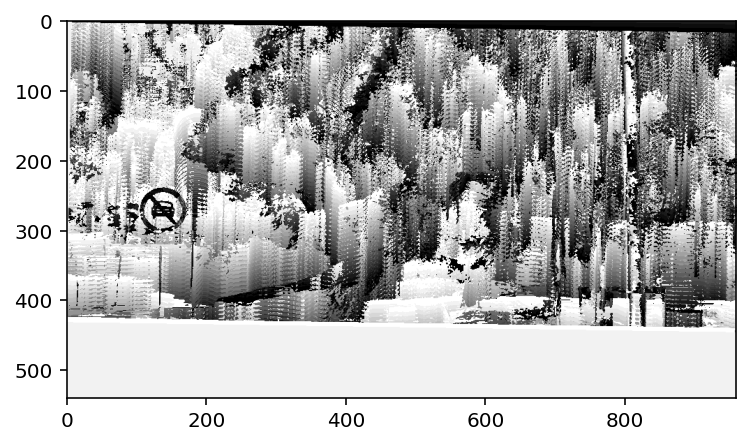

[18 18 18 ... 18 18 18]


In [11]:
mLambda = 1
labels = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, 1*pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

In [12]:
# for i in range(0,unaryCosts.shape[0]):
#     for j in range(0, unaryCosts.shape[1]):
#         print(unaryCosts[i, j])